In [130]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.util as util
import torch
import torch.nn as nn
import torch.nn.functional as F
import igraph as ig
from igraph import Graph
import sklearn.metrics as metrics
import warnings
import time
from tqdm import tqdm
import skimage.filters
warnings.filterwarnings("ignore")
%load_ext line_profiler

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [131]:
def show(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def generate_square(size=(224, 224), fore_back_ratio=0.5, noise=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    square_width = int(np.sqrt(fore_back_ratio * size[0] * size[1]))
    square_position_x = np.random.randint(0, size[0] - square_width)
    square_position_y = np.random.randint(0, size[1] - square_width)
    image = np.ones(size)
    image[square_position_x:square_position_x+square_width, square_position_y:square_position_y+square_width] = 0
    return image

def add_noise(image, amount=0.5, seed=None):
    image = util.random_noise(image, mode='gaussian', seed=seed, clip=False, var=amount)
    image = image / np.max(image)
    return image

def generate_image(size=(224, 224), fore_back_ratio=0.5, noise=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    image = generate_square(size, fore_back_ratio, noise, seed)
    pixelwise_labels = image.copy()
    image = add_noise(image, amount=noise, seed=seed)
    return image, pixelwise_labels

def tile(image, pixelwise_labels=None, method='grid', d=10):
    if method == 'grid':
        if image.shape[0] % d != 0 or image.shape[1] % d != 0:
            raise ValueError('image shape must be divisible by d')
        else:
            tile_width = (image.shape[0] // d)
            tile_height = (image.shape[1] // d)
            image_tensor = torch.tensor(image, dtype=torch.float32)
            if len(image_tensor.shape) < 3:
                image_tensor = image_tensor.unsqueeze(2)
            tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
            tiles = tiles.permute(0, 1, 3, 4, 2)
            tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])

            if pixelwise_labels is not None:
                pixelwise_labels_tensor = torch.tensor(pixelwise_labels)
                if len(pixelwise_labels_tensor.shape) < 3:
                    image_tensor = image_tensor.unsqueeze(2)
                pixelwise_labels_tiles = pixelwise_labels_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
                pixelwise_labels_tiles = pixelwise_labels_tiles.reshape(pixelwise_labels_tiles.shape[0] * pixelwise_labels_tiles.shape[1], tile_width * tile_height)
                tilewise_labels = pixelwise_labels_tiles.mean(axis=1).round()
                return tiles, tilewise_labels
            else:
                return tiles
    else:
        raise ValueError('method not implemented')
    

def arbitrary_labels(n, proportion=0.5, seed=None):
    if seed is not None:
        torch.random.manual_seed(seed)
    randoms = torch.rand(n)
    labels = torch.zeros(n)
    labels[randoms > proportion] = 1
    return labels

def generate_tiles(size=(224, 224), fore_back_ratio=0.5, noise=0.5, d=8, seed=None):
    if seed is not None:
        np.random.seed(seed)
    image, pixelwise_labels = generate_image(size, fore_back_ratio, noise, seed)
    tiles, tilewise_labels = tile(image, pixelwise_labels, d=d)
    return tiles, tilewise_labels, arbitrary_labels(tilewise_labels.shape[0], seed=seed)

def visualize_tiles(tiles, tilewise_labels=None, show_labels=True):
    d = int(np.sqrt(tiles.shape[0]))
    fig, axs = plt.subplots(d,d, figsize=(d//2,d//2))
    for i in range(d):
        for j in range(d):
            axs[i, j].imshow(tiles[i * d + j], cmap='gray', vmin=0, vmax=1)
            if show_labels and tilewise_labels is not None:
                axs[i, j].text(2, 2, f'{tilewise_labels[i * d + j]:.2f}', color='white', fontsize=6, bbox=dict(fill=True, facecolor='purple', linewidth=0), verticalalignment='top', horizontalalignment='left')
            axs[i, j].axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()



In [136]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_shape, n_filters, n_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_filters, 3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, n_filters, 3, padding=1)
        self.conv3 = nn.Conv2d(n_filters, 1, 3, padding=1)
        self.output = nn.Linear(input_shape[0] * input_shape[1], 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x

def graph_cut(d, probabilities, lambda_):
    g = Graph.Lattice(dim=[d, d], circular=False)
    g.add_vertices(2)
    weights = np.zeros(g.ecount() + (2*d*d))
    s = d*d
    t = s + 1
    st_edges = np.array([(i, s) for i in range(d*d)] + [(i, t) for i in range(d*d)])
    g.add_edges(st_edges)
    weights[:-2*d*d] = lambda_
    scaled_probabilities = (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    weights[-2*d*d:-1*d*d] = scaled_probabilities
    weights[-1*d*d:] = 1 - scaled_probabilities
    g.es['weight'] = weights

    colors = np.concatenate((np.zeros(d*d), np.array([1,2])))
    g.vs["color"] = ["gray" if c == 0 else ("black" if c == 1 else "white") for c in colors]

    # assignments = np.array(g.maxflow(s, t, "weight").membership[:-2])

    mc = g.st_mincut(s, t, "weight")
    bg = mc.partition[0]
    bg.remove(s)
    assignments = np.zeros(d*d)
    assignments[bg] = 1
    return assignments, g

def visualize_graph(g, d, labels=None):
    if labels is None:
        colors = np.concatenate((np.zeros(d*d), np.array([2,3])))
        g.vs["color"] = ["gray" if c == 0 else ("black" if c == 2 else "white") for c in colors]
    else:
        colors = np.concatenate((labels.astype(int), np.array([1,0])))
        g.vs["color"] = ["black" if c == 0 else "white" for c in colors]

    fig, ax = plt.subplots(figsize=(8,8))
    layout = np.zeros((d*d + 2, 2))
    for i in range(d*d + 2):
        if i < d*d:
            layout[i, 0] = (i % d)
            layout[i, 1] = -1 * (i // d)
        elif i == d*d:
            layout[i, 1] = 2
            layout[i, 0] = (d - 1) / 2
        elif i == d*d + 1:
            layout[i, 1] = -1 * (d + 1)
            layout[i, 0] = (d - 1) / 2

    n_edges = g.ecount()
    n_lattice_edges = n_edges - 2*d*d
            
    ig.plot(g, target=ax, edge_width=g.es["weight"], layout=layout)
    plt.show()

def train(X, y_initial, d, iterations=10, lr=0.01, lambda_=0.1, net_params=None, batch_size=None, subset_size=0.5):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y_initial = torch.tensor(y_initial, dtype=torch.float32).to(device)
    if batch_size == None:
        batch_size = X.shape[0]
    y_intermediate = y_initial.clone().detach()
    losses = []
    intermediate_partitions = []
    intermediate_probabilities = []
    intermediate_graphs = []

    # instantiate net
    net = MLP(net_params[0], net_params[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for iteration in range(iterations):
        # extract subset of data
        idx = torch.randperm(X.shape[0])
        X_shuffled = X[idx]
        y_intermediate_shuffled = y_intermediate[idx]
        X_subset = X_shuffled[:int(subset_size * X.shape[0])]
        y_intermediate_subset = y_intermediate_shuffled[:int(subset_size * X.shape[0])]

        # split X and y_intermediate into batches
        X_batches = torch.split(X_subset, batch_size)
        y_intermediate_batches = torch.split(y_intermediate_subset, batch_size)

        # train on batches
        iteration_loss = 0
        for batch_i in range(len(X_batches)):
            inputs = X_batches[batch_i]
            labels = y_intermediate_batches[batch_i].unsqueeze(1)
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.float32).to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            iteration_loss += loss.item()
            loss.backward()
            optimizer.step()

        # save loss
        losses.append(iteration_loss / X.shape[0])
        
        # update y_intermediate
        probabilities = net(X).detach().squeeze(1).cpu().numpy()
        partition, g = graph_cut(d, probabilities, lambda_)
        intermediate_partitions.append(partition)
        intermediate_probabilities.append(probabilities)
        intermediate_graphs.append(g)
        y_intermediate = torch.Tensor(partition).to(device)
    return net, losses, intermediate_partitions, intermediate_probabilities, intermediate_graphs

def train_CNN(X, y_initial, d, iterations=10, lr=0.01, lambda_=0.1, net_params=None, batch_size=None, subset_size=0.5, n_filters=16):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y_initial = torch.tensor(y_initial, dtype=torch.float32).to(device)
    if batch_size == None:
        batch_size = X.shape[0]
    y_intermediate = y_initial.clone().detach()
    losses = []
    intermediate_partitions = []
    intermediate_probabilities = []
    intermediate_graphs = []

    # instantiate net
    net = CNN((X.shape[-2], X.shape[-1]), n_filters, n_channels=X.shape[-3]).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for iteration in range(iterations):
        # extract subset of data
        idx = torch.randperm(X.shape[0])
        X_shuffled = X[idx]
        y_intermediate_shuffled = y_intermediate[idx]
        X_subset = X_shuffled[:int(subset_size * X.shape[0])]
        y_intermediate_subset = y_intermediate_shuffled[:int(subset_size * X.shape[0])]

        # split X and y_intermediate into batches
        X_batches = torch.split(X_subset, batch_size)
        y_intermediate_batches = torch.split(y_intermediate_subset, batch_size)

        # train on batches
        iteration_loss = 0
        for batch_i in range(len(X_batches)):
            inputs = X_batches[batch_i]
            labels = y_intermediate_batches[batch_i].unsqueeze(1)
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.float32).to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            iteration_loss += loss.item()
            loss.backward()
            optimizer.step()

        # save loss
        losses.append(iteration_loss / X.shape[0])
        
        # update y_intermediate
        probabilities = net(X).detach().squeeze(1).cpu().numpy()
        partition, g = graph_cut(d, probabilities, lambda_)
        intermediate_partitions.append(partition)
        intermediate_probabilities.append(probabilities)
        intermediate_graphs.append(g)
        y_intermediate = torch.Tensor(partition).to(device)
    return net, losses, intermediate_partitions, intermediate_probabilities, intermediate_graphs
        

def vote(labelings, leniency=4):
    label_shape = labelings[0].shape
    votes = np.zeros(label_shape)
    for labeling in labelings:
        votes += labeling
    ensemble = (votes > len(labelings) / leniency).astype(int)
    plt.hist(votes)
    plt.show()
    return ensemble

def auto_threshold(probabilities):
    t = skimage.filters.threshold_otsu(probabilities)
    return t

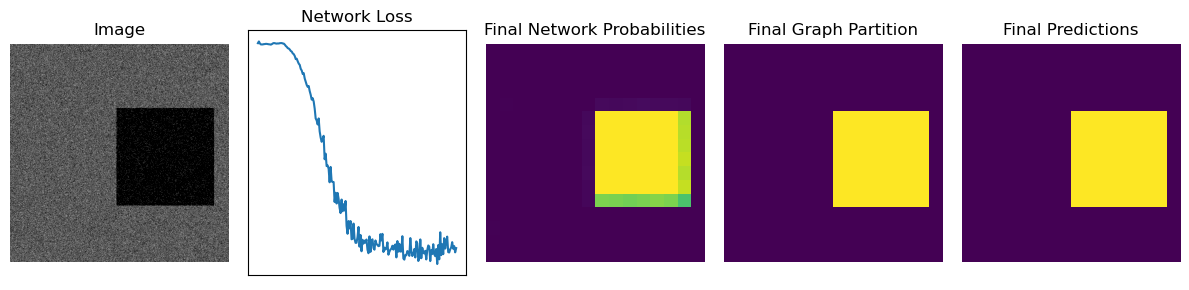

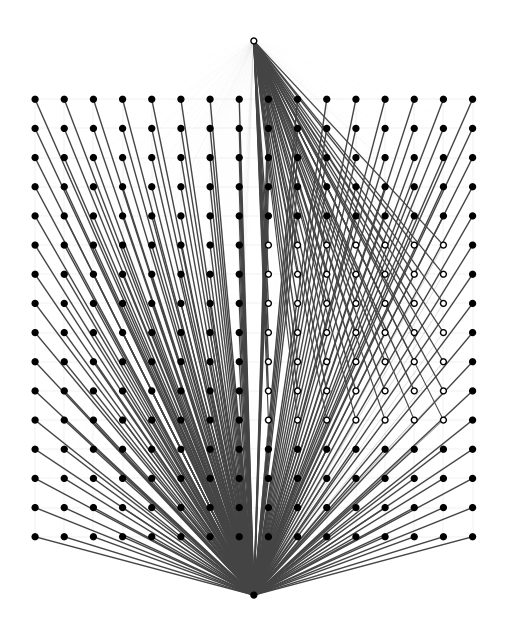

In [145]:
size = (512, 512)
d = 16
fore_back_ratio = 0.2
noise = 0.2
seed = 3
image, pixelwise_labels = generate_image(size, fore_back_ratio, noise, seed)
X, y_gt, y_initial = generate_tiles(size=size, fore_back_ratio=fore_back_ratio, noise=noise, d=d, seed=seed)
X = X.permute(0, 3, 1, 2)
    
net, losses, intermediate_partitions, intermediate_probabilities, intermediate_graphs = train_CNN(X, y_initial, d, iterations=200, lr=0.0001, lambda_=0.05, net_params=[(size[0]//d)*(size[1]//d), 16], subset_size=0.5)
predictions = intermediate_probabilities[-1] > auto_threshold(intermediate_probabilities[-1])

# show plots side by side
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
axs[0].set_title('Image')
axs[0].axis('off')
axs[0].imshow(image, cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Network Loss')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].plot(losses)
axs[2].set_title('Final Network Probabilities')
axs[2].axis('off')
axs[2].imshow(intermediate_probabilities[-1].reshape(d, d))
axs[3].set_title('Final Graph Partition')
axs[3].axis('off')
axs[3].imshow(intermediate_partitions[-1].reshape(d, d))
axs[4].set_title('Final Predictions')
axs[4].axis('off')
axs[4].imshow(predictions.reshape(d, d))
plt.tight_layout()
plt.show()

visualize_graph(intermediate_graphs[-1], d, labels=predictions)

100%|██████████| 57/57 [00:39<00:00,  1.43it/s]


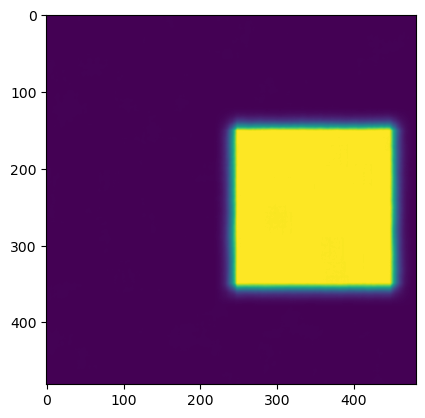

In [146]:
# set up a custom dataloader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]
        
def predict_image(image, d, net):
    image_tensor = torch.tensor(image, dtype=torch.float32)
    all_tiles = image_tensor.unfold(0, image.shape[0]//d, 1).unfold(1, image.shape[1]//d, 1).reshape(-1, 1, image.shape[0]//d, image.shape[1]//d).to(device)

    all_tiles_ds = CustomDataset(all_tiles)

    # set up dataloaders
    loader = torch.utils.data.DataLoader(all_tiles_ds, batch_size=4096, shuffle=False)
    n_batches = len(loader)

    with torch.no_grad():
        all_tiles_predictions = torch.zeros((len(all_tiles_ds))).to(device)
        for batch_i, batch in tqdm(enumerate(loader), total=n_batches):
            batch_predictions = net(batch)
            all_tiles_predictions[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size] = batch_predictions.squeeze(1)

    return all_tiles_predictions.reshape(image.shape[0] - ((image.shape[0] // d) - 1), image.shape[1] - ((image.shape[1] // d) - 1))

predictions = predict_image(image, d, net)
predictions = predictions.detach().cpu().numpy()
plt.imshow(predictions)